In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask

import shapely
import geopandas as gpd
import salem

import ecco_v4_py as ecco

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [4]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})
budg = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_budgets/').rename({'face': 'tile'})

In [5]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','tile','j','i')

In [6]:
# Volume fluxes (m^3/s)
budg_vol = budg*vol

### Define the section lines 

In [7]:
ptDaS1,ptDaS2 = ecco.get_section_endpoints('Davis Strait')
ptDeS1,ptDeS2 = ecco.get_section_endpoints('Denmark Strait')
ptIF1,ptIF2 = ecco.get_section_endpoints('Iceland Faroe')
ptFS1,ptFS2 = ecco.get_section_endpoints('Faroe Scotland')
ptSN1,ptSN2 = ecco.get_section_endpoints('Scotland Norway')
ptFrS1,ptFrS2 = ecco.get_section_endpoints('Fram Strait')
ptSvN1,ptSvN2 = ecco.get_section_endpoints('Barents Sea')
ptLG1,ptLG2 = ecco.get_section_endpoints('Labrador Greenland')
ptHS1,ptHS2 = ecco.get_section_endpoints('Hudson Strait')
ptEC1,ptEC2 = ecco.get_section_endpoints('English Channel')
ptSB1,ptSB2 = ecco.get_section_endpoints('Newfoundland Iberia')
ptBS1,ptBS2 = ecco.get_section_endpoints('Bering Strait')

maskC_DaS, maskW_DaS, maskS_DaS = ecco.get_section_line_masks(ptDaS1,ptDaS2,main)
maskC_DeS, maskW_DeS, maskS_DeS = ecco.get_section_line_masks(ptDeS1,ptDeS2,main)
maskC_IF, maskW_IF, maskS_IF = ecco.get_section_line_masks(ptIF1,ptIF2,main)
maskC_FS, maskW_FS, maskS_FS = ecco.get_section_line_masks(ptFS1,ptFS2,main)
maskC_SN, maskW_SN, maskS_SN = ecco.get_section_line_masks(ptSN1,ptSN2,main)
maskC_FrS, maskW_FrS, maskS_FrS = ecco.get_section_line_masks(ptFrS1,ptFrS2,main)
maskC_SvN, maskW_SvN, maskS_SvN = ecco.get_section_line_masks(ptSvN1,ptSvN2,main)
maskC_LG, maskW_LG, maskS_LG = ecco.get_section_line_masks(ptLG1,ptLG2,main)
maskC_HS, maskW_HS, maskS_HS = ecco.get_section_line_masks(ptHS1,ptHS2,main)
maskC_EC, maskW_EC, maskS_EC = ecco.get_section_line_masks(ptEC1,ptEC2,main)
maskC_SB, maskW_SB, maskS_SB = ecco.get_section_line_masks(ptSB1,ptSB2,main)
maskC_BS, maskW_BS, maskS_BS = ecco.get_section_line_masks(ptBS1,ptBS2,main)

In [8]:
# Reference salinity
Sref = 35.0

In [9]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

In [10]:
# Remove oceFWflx from WVELMASS
WVELMASS = main.WVELMASS.transpose('time','tile','k_l','j','i')
oceFWflx = main.oceFWflx.assign_coords(k_l=0).expand_dims('k_l').transpose('time','tile','k_l','j','i')

oceFWflx = (oceFWflx/rhoconst)
WVELMASS = xr.concat([WVELMASS.sel(k_l=0) + oceFWflx, WVELMASS[:,:,1:]], 
                     dim='k_l').transpose('time','tile','k_l','j','i')

In [11]:
grid = ecco.get_llc_grid(main)

In [12]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')
SALT_at_w = grid.interp(main.SALT, 'Z', boundary='extend')

In [13]:
# Freshwater advective (Eulerian) fluxes (m^3/s)
ADVx_FWe = main.UVELMASS*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FWe = main.VVELMASS*main.dxG*main.drF*(Sref-SALT_at_v)/Sref
ADVr_FWe = WVELMASS*main.rA*(Sref-SALT_at_w)/Sref

In [14]:
# Freshwater advective (Bolus) fluxes (m^3/s)
ADVx_FWb = main.UVELSTAR*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FWb = main.VVELSTAR*main.dxG*main.drF*(Sref-SALT_at_v)/Sref
ADVr_FWb = main.WVELSTAR*main.rA*(Sref-SALT_at_w)/Sref

In [15]:
# Volumetric transport
x_vol = main['UVELMASS'] * main['drF'] * main['dyG'] 
y_vol = main['VVELMASS'] * main['drF'] * main['dxG'] 

### Calculate section transports

In [16]:
sections = ['Davis Strait', 'Denmark Strait', 'Iceland Faroe', 'Faroe Scotland', 'Scotland Norway',
           'Fram Strait','Barents Sea','Labrador Greenland', 'Hudson Strait','English Channel','Newfoundland Iberia',
           'Bering Strait']

vol_trsp = []
fw_etrsp = []
fw_btrsp = []

for name in sections:
    print(name)
    pt1,pt2 = ecco.get_section_endpoints(name)
    maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)
    
    # Volume transports
    sec_trsp_x = (x_vol[:,:2] * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (y_vol[:,:2] * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    vol_trsp.append(sec_trsp*Sv)

    # Freshwater transports (Eulerian)
    sec_trsp_x = (ADVx_FWe[:,:2] * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (ADVy_FWe[:,:2] * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    fw_etrsp.append(sec_trsp*Sv)
    
    # Freshwater transports (Bolus)
    sec_trsp_x = (ADVx_FWb[:,:2] * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (ADVy_FWb[:,:2] * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    fw_btrsp.append(sec_trsp*Sv)

Davis Strait
Denmark Strait
Iceland Faroe
Faroe Scotland
Scotland Norway
Fram Strait
Barents Sea
Labrador Greenland
Hudson Strait
English Channel
Newfoundland Iberia
Bering Strait


In [21]:
vol_trsp = xr.concat(vol_trsp,pd.Index(sections, name='section'))
fw_etrsp = xr.concat(fw_etrsp,pd.Index(sections, name='section'))
fw_btrsp = xr.concat(fw_btrsp,pd.Index(sections, name='section'))

In [22]:
ds = vol_trsp.to_dataset(name='vol')
ds['fwe'] = fw_etrsp
ds['fwb'] = fw_btrsp

In [23]:
ds.sel(time=slice('1993-01-01','2015-12-31')).mean('time').to_dataframe()

,vol,fwe,fwb
section,,,
Davis Strait,-0.282534,-0.023250,-0.011468
Denmark Strait,-0.192365,-0.009458,-0.008318
Iceland Faroe,0.241728,-0.001250,-0.000576
Faroe Scotland,0.596792,-0.004134,0.000082
Scotland Norway,-0.265257,0.003843,0.000066
Fram Strait,-0.230986,-0.015698,-0.012937
Barents Sea,0.319354,-0.000716,-0.003679
Labrador Greenland,-0.484590,-0.039876,-0.001348
Hudson Strait,-0.128695,-0.022257,-0.005831


In [24]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_section_transports_fw_20m.nc', format='NETCDF4')

In [16]:
vol_trsp = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw_20m.nc').vol
fw_etrsp = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw_20m.nc').fwe
fw_btrsp = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw_20m.nc').fwb

In [17]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [18]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [19]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

In [20]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

### Volume Budget

In [28]:
terms = ['tendV', 'forcV', 'hConvV', 'vConvV', 'ConvV', 'totalV', 'w_trspV']

In [56]:
budg_volume = []
for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Volume tendency (m^3/s)
    tendV = (budg_vol.tendV[:,:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sea surface forcing on volume (m^3/s)
    forcV = (budg_vol.forcV[:,:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Convergence of volume transport (m^3/s)
    hConvV = (budg_vol.hConvV[:,:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    vConvV = (budg_vol.vConvV[:,:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    ConvV = hConvV + vConvV
    
    # Sum of terms (m^3/s)
    totalV = ConvV + forcV
    
    # Vertical volume transport (m^3/s)
    w_trspV = ((WVELMASS[:,:,2]*main.rA)*mask.where(mask==1)).sum(dim=['tile','j','i'])
    
    results = dask.compute(tendV.reset_coords(drop=True)*Sv, forcV.reset_coords(drop=True)*Sv, 
                           hConvV.reset_coords(drop=True)*Sv, vConvV.reset_coords(drop=True)*Sv, 
                           ConvV.reset_coords(drop=True)*Sv, totalV.reset_coords(drop=True)*Sv, 
                           w_trspV.reset_coords(drop=True)*Sv)
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_volume.append(budg)

In [57]:
region = ['spna', 'nsea', 'lsea']
budg_volume = xr.concat(budg_volume,pd.Index(region, name='region'))

#### Save to netcdf

In [58]:
ds = budg_volume.reset_coords(drop=True).to_dataset(name='budg_vol')

In [30]:
#ds.to_netcdf('/mnt/efs/data/ecco/ecco_budg_vol_20m.nc', format='NETCDF4')
budg_volume = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_vol_20m.nc').budg_vol

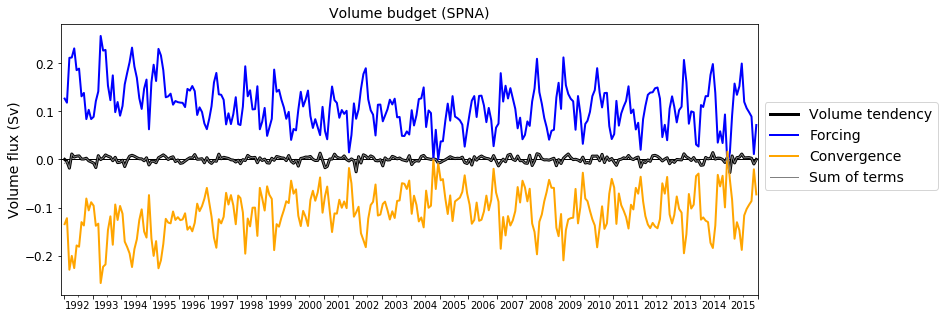

In [60]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Volume budget (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='tendV'), lw=3, color='black',label='Volume tendency')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='forcV'), lw=2, color='blue',label='Forcing')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='ConvV'), lw=2, color='orange',label='Convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='totalV'), lw=1, color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

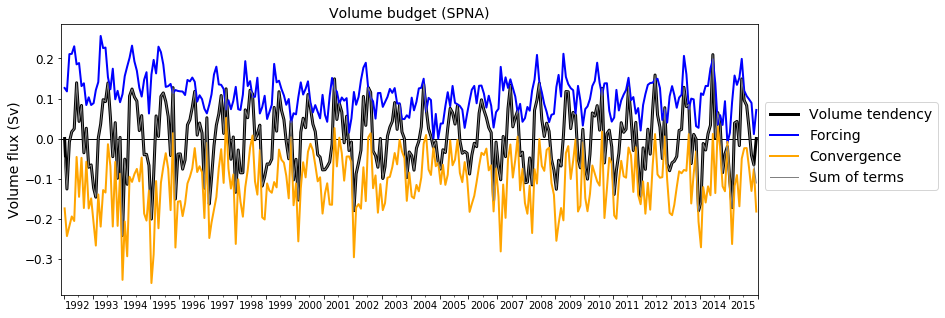

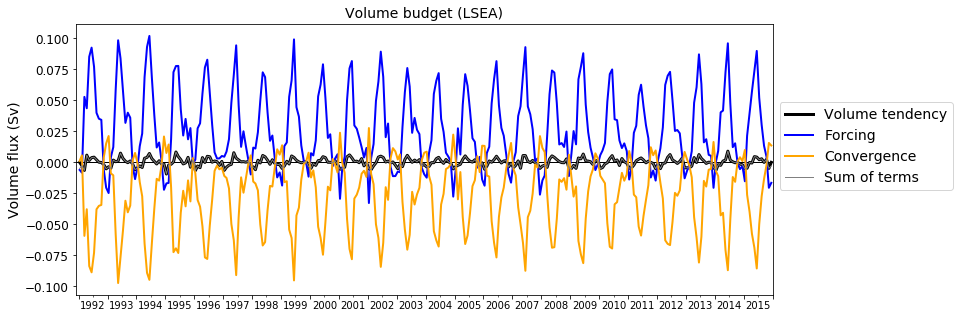

In [61]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Volume budget (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='tendV'), lw=3, color='black',label='Volume tendency')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='forcV'), lw=2, color='blue',label='Forcing')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='ConvV'), lw=2, color='orange',label='Convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='totalV'), lw=1, color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

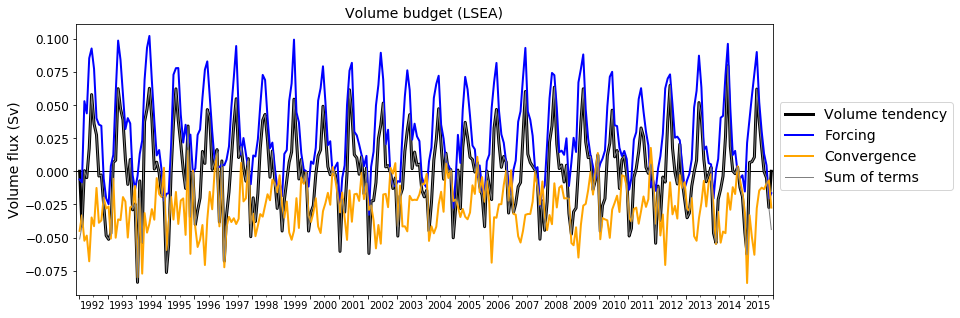

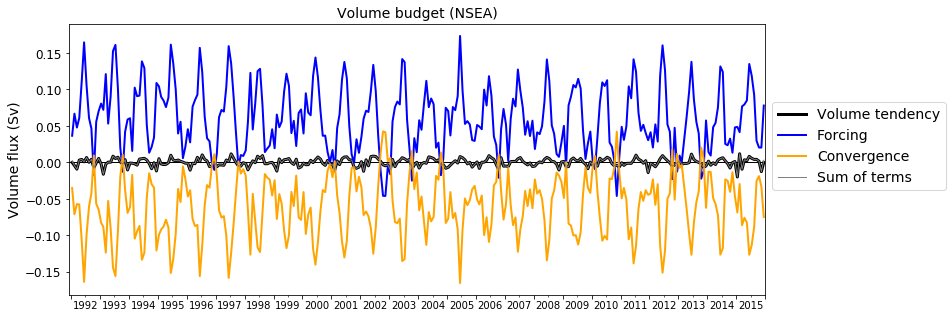

In [62]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Volume budget (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='tendV'), lw=3, color='black',label='Volume tendency')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='forcV'), lw=2, color='blue',label='Forcing')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='ConvV'), lw=2, color='orange',label='Convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='totalV'), lw=1, color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

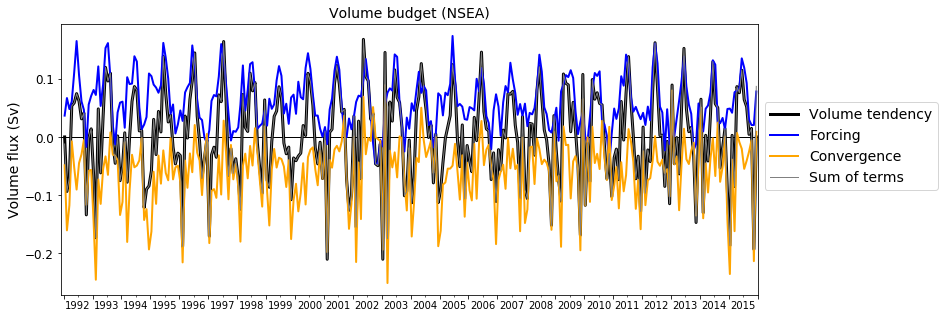

In [25]:
ConvV_spna_bnd = vol_trsp.sel(section='Newfoundland Iberia') + vol_trsp.sel(section='English Channel') \
                    - vol_trsp.sel(section='Hudson Strait') - vol_trsp.sel(section='Davis Strait') \
                    - vol_trsp.sel(section='Denmark Strait') - vol_trsp.sel(section='Iceland Faroe') \
                    - vol_trsp.sel(section='Faroe Scotland')

In [26]:
ConvV_nsea_bnd = vol_trsp.sel(section='Denmark Strait') + vol_trsp.sel(section='Iceland Faroe') \
                    + vol_trsp.sel(section='Faroe Scotland') + vol_trsp.sel(section='Scotland Norway') \
                    - vol_trsp.sel(section='Fram Strait') - vol_trsp.sel(section='Barents Sea')

In [27]:
ConvV_lsea_bnd = vol_trsp.sel(section='Labrador Greenland') - vol_trsp.sel(section='Hudson Strait') \
                    - vol_trsp.sel(section='Davis Strait')

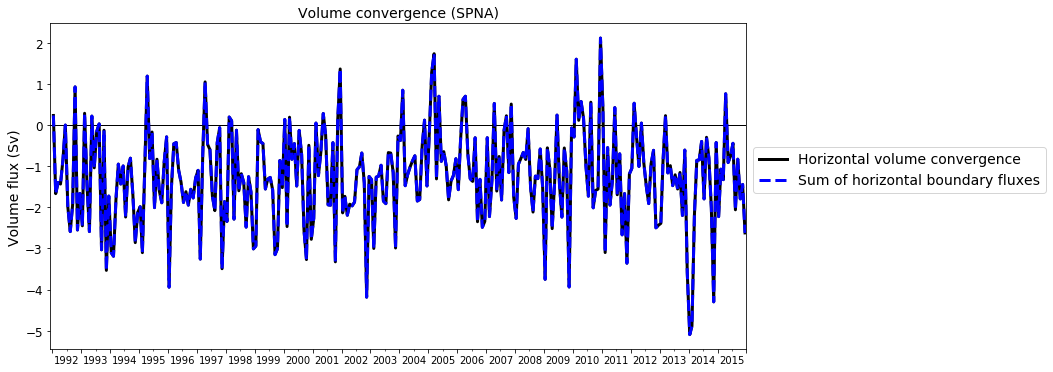

In [35]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='hConvV'), lw=3, color='k',
        label='Horizontal volume convergence')
ax.plot(ConvV_spna_bnd.time, ConvV_spna_bnd, lw=3, color='b',ls='--',label='Sum of horizontal boundary fluxes')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

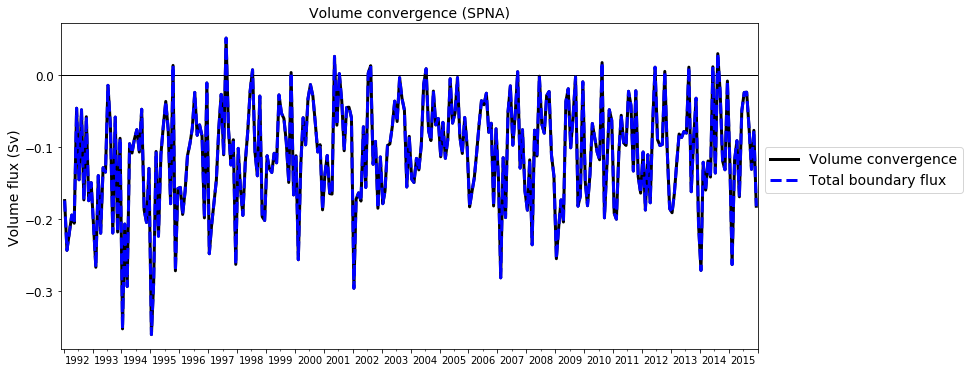

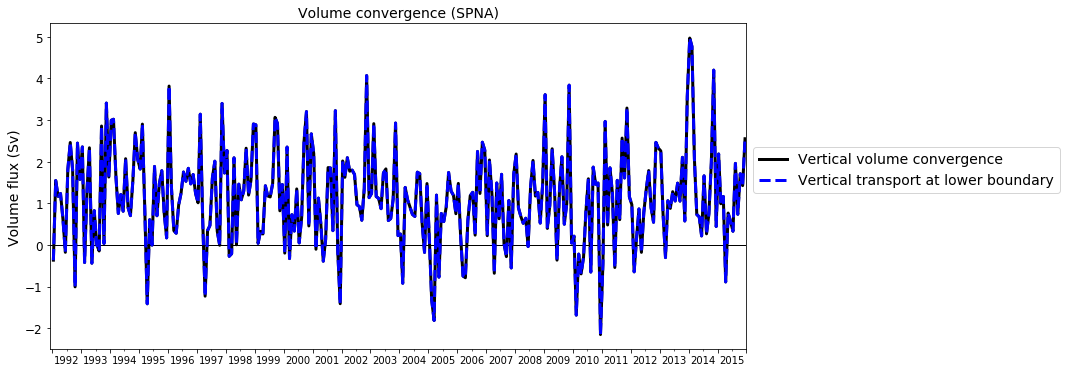

In [22]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='vConvV'), lw=3, color='k',
        label='Vertical volume convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='w_trspV'), lw=3, color='b',ls='--',
        label='Vertical transport at lower boundary')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

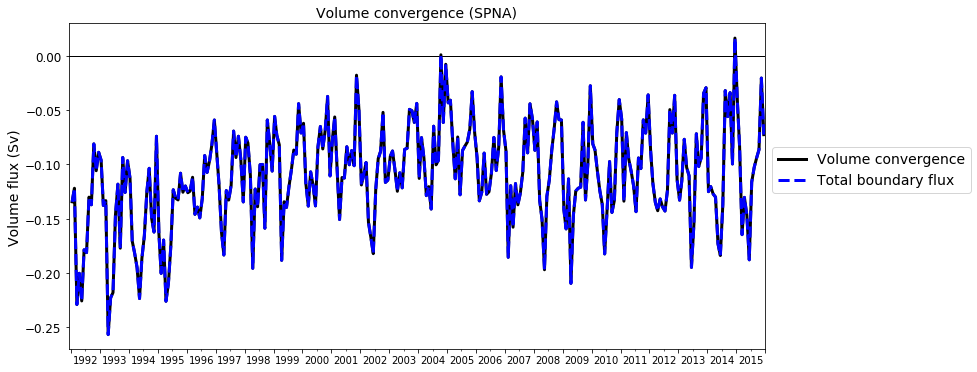

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='ConvV'), lw=3, color='k',
        label='Volume convergence')
ax.plot(ConvV_spna_bnd.time, ConvV_spna_bnd+budg_volume.sel(region='spna',term='w_trspV'), lw=3, color='b',ls='--',
        label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

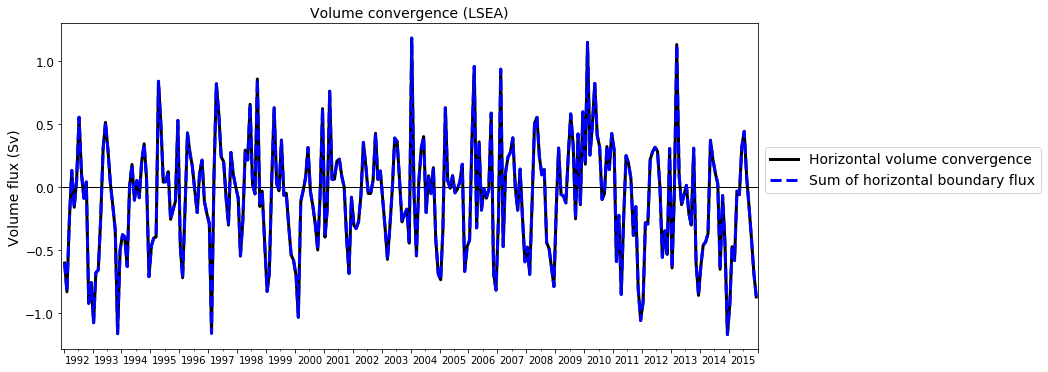

In [34]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='hConvV'), lw=3, color='k',
        label='Horizontal volume convergence')
ax.plot(ConvV_lsea_bnd.time, ConvV_lsea_bnd, lw=3, color='b',ls='--',label='Sum of horizontal boundary fluxes')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

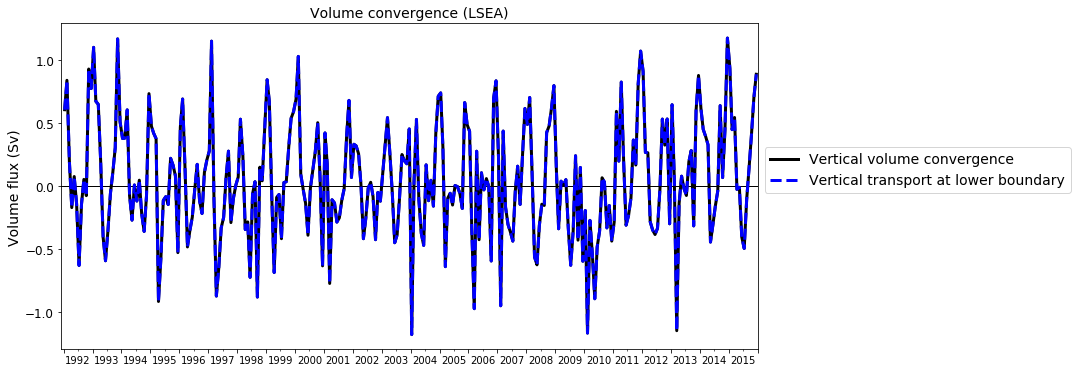

In [30]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='vConvV'), lw=3, color='k',
        label='Vertical volume convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='w_trspV'), lw=3, color='b',ls='--',
        label='Vertical transport at lower boundary')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

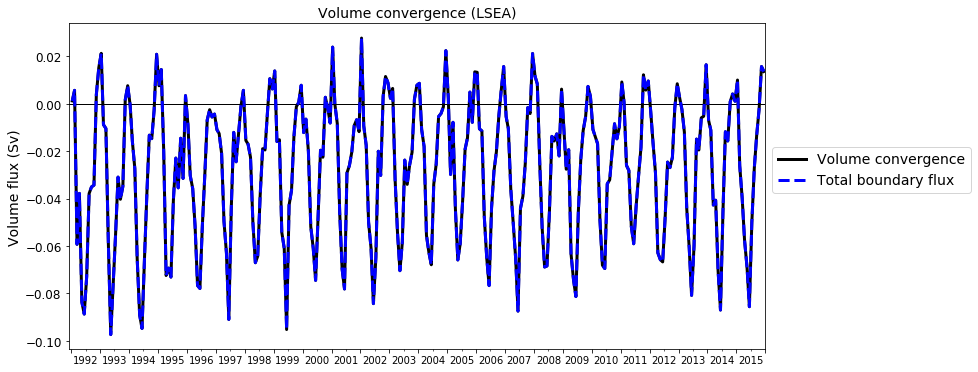

In [31]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='ConvV'), lw=3, color='k',
        label='Volume convergence')
ax.plot(ConvV_lsea_bnd.time, ConvV_lsea_bnd+budg_volume.sel(region='lsea',term='w_trspV'), lw=3, color='b',ls='--',
        label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

### Freshwater budget

In [21]:
# Liquid freshwater content (m^3)
lfwc = ((Sref - main.SALT)/Sref)*vol

In [22]:
def conv3d(ADVx, ADVy, ADVr):
    
    ADVxy_diff = grid.diff_2d_vector({'X' : ADVx, 'Y' : ADVy}, boundary = 'fill')
    adv_hConv = -(ADVxy_diff['X'] + ADVxy_diff['Y'])
    adv_vConv = grid.diff(ADVr, 'Z', boundary='fill')
    
    return adv_hConv, adv_vConv

In [23]:
# Freshwater tendency (m^3/s)
tendFw = grid.diff((Sref-main.SALT_snp)/Sref, 'T', boundary='fill', fill_value=0.0)*vol/main.dt

# Freshwater forcing (m^3/s)
forcFw = main.oceFWflx/rhoconst*main.rA

In [24]:
# Convergence
adv_hConvFWe, adv_vConvFWe = conv3d(ADVx_FWe, ADVy_FWe, ADVr_FWe)
adv_hConvFWb, adv_vConvFWb = conv3d(ADVx_FWb, ADVy_FWb, ADVr_FWb)
adv_hConvFw, adv_vConvFw = conv3d(ADVx_FWe+ADVx_FWb, ADVy_FWe+ADVy_FWb, ADVr_FWe+ADVr_FWb)

In [25]:
terms = ['tendFw', 'forcFw', 
         'adv_hConvFWe', 'adv_vConvFWe', 'adv_ConvFWe', 
         'adv_hConvFWb', 'adv_vConvFWb', 'adv_ConvFWb', 
         'adv_hConvFw', 'adv_vConvFw', 'adv_ConvFw', 
         'totalFw', 
         'w_trspFWe', 'w_trspFWb', 
         'lfwc', 'psal']

budg_fw = []

for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
        
    # Freshwater tendency (m^3/s)
    tendFw_mask = (tendFw[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Freshwater forcing (m^3/s)
    forcFw_mask = (forcFw*mask.where(mask==1)).sum(dim=['tile','j','i'])
    
    # Convergence of eularian advection (m^3/s)
    adv_hConvFWe_mask = (adv_hConvFWe[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_vConvFWe_mask = (adv_vConvFWe[:,:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_ConvFWe_mask = ((adv_hConvFWe+adv_vConvFWe)[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Convergence of bolus advection (m^3/s)
    adv_hConvFWb_mask = (adv_hConvFWb[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_vConvFWb_mask = (adv_vConvFWb[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_ConvFWb_mask = ((adv_hConvFWb+adv_vConvFWb)[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
        
    # Convergence of total advection (m^3/s)
    adv_hConvFw_mask = (adv_hConvFw[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_vConvFw_mask = (adv_vConvFw[:,:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    adv_ConvFw_mask = ((adv_hConvFw+adv_vConvFw)[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sum of terms (m^3/s)
    totalFw_mask = forcFw_mask + adv_ConvFw_mask
    
    # Vertical eularian transport (m^3/s)
    w_trspFWe = (ADVr_FWe[:,:,2]*mask.where(mask==1)).sum(dim=['tile','j','i'])
    
    # Vertical bolus transport (m^3/s)
    w_trspFWb = (ADVr_FWb[:,2]*mask.where(mask==1)).sum(dim=['tile','j','i'])
    
    # Liquid freshwater content (m^3)
    lfwc_mask = (lfwc[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Average salinity (psu)
    psal = ((main.SALT*vol)[:,:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])\
            /(vol[:2]*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    results = dask.compute(tendFw_mask.reset_coords(drop=True)*Sv, forcFw_mask.reset_coords(drop=True)*Sv, 
                           adv_hConvFWe_mask.reset_coords(drop=True)*Sv, adv_vConvFWe_mask.reset_coords(drop=True)*Sv,
                           adv_ConvFWe_mask.reset_coords(drop=True)*Sv,
                           adv_hConvFWb_mask.reset_coords(drop=True)*Sv, adv_vConvFWb_mask.reset_coords(drop=True)*Sv,
                           adv_ConvFWb_mask.reset_coords(drop=True)*Sv,
                           adv_hConvFw_mask.reset_coords(drop=True)*Sv, adv_vConvFw_mask.reset_coords(drop=True)*Sv,
                           adv_ConvFw_mask.reset_coords(drop=True)*Sv,
                           totalFw_mask.reset_coords(drop=True)*Sv, 
                           w_trspFWe.reset_coords(drop=True)*Sv, w_trspFWb.reset_coords(drop=True)*Sv,
                           lfwc_mask.reset_coords(drop=True), psal.reset_coords(drop=True))
    
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_fw.append(budg)

In [26]:
region = ['spna', 'nsea', 'lsea']
budg_fw = xr.concat(budg_fw,pd.Index(region, name='region'))

In [27]:
dif_ConvFw = budg_fw.sel(term='tendFw') - budg_fw.sel(term='totalFw')
budg_fw = xr.concat([budg_fw, dif_ConvFw.assign_coords(term='dif_ConvFw')], dim='term')

#### Save to netcdf

In [28]:
ds = budg_fw.reset_coords(drop=True).to_dataset(name='budg_fw')

In [29]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_budg_fw_20m.nc', format='NETCDF4')

### Plots

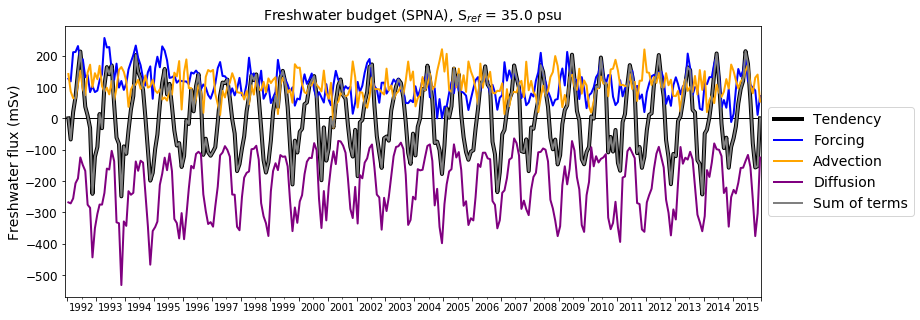

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (SPNA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='tendFw')*1e3, lw=4, color='black',label='Tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFw')*1e3, lw=2, color='blue',label='Forcing')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term=['forcFw', 'adv_ConvFw', 'dif_ConvFw']).sum('term')*1e3, lw=2, 
        color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

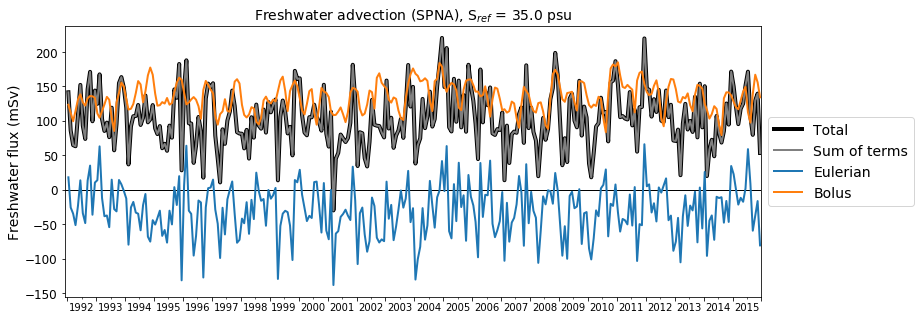

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater advection (SPNA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_ConvFw')*1e3, lw=4, color='black',
        label='Total')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term=['adv_ConvFWe', 'adv_ConvFWb']).sum('term')*1e3, lw=2, 
        color='grey',label='Sum of terms')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_ConvFWe')*1e3, lw=2,label='Eulerian')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_ConvFWb')*1e3, lw=2,label='Bolus')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

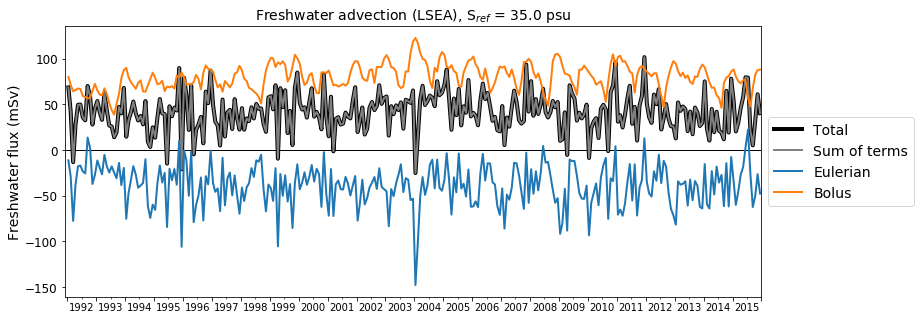

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater advection (LSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='adv_ConvFw')*1e3, lw=4, color='black',
        label='Total')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term=['adv_ConvFWe', 'adv_ConvFWb']).sum('term')*1e3, lw=2, 
        color='grey',label='Sum of terms')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='adv_ConvFWe')*1e3, lw=2,label='Eulerian')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='adv_ConvFWb')*1e3, lw=2,label='Bolus')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

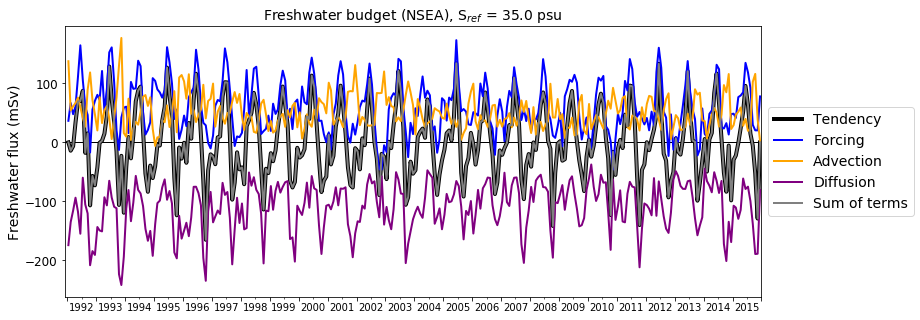

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (NSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='tendFw')*1e3, lw=4, color='black',label='Tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFw')*1e3, lw=2, color='blue',label='Forcing')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term=['forcFw', 'adv_ConvFw', 'dif_ConvFw']).sum('term')*1e3, lw=2, 
        color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

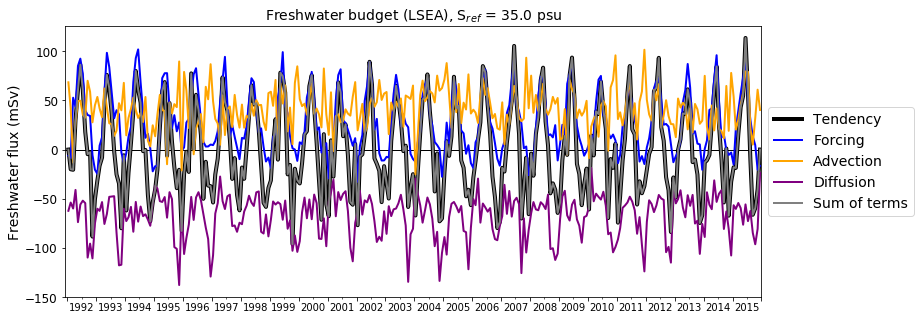

In [34]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (LSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='tendFw')*1e3, lw=4, color='black',label='Tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='forcFw')*1e3, lw=2, color='blue',label='Forcing')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term=['forcFw', 'adv_ConvFw', 'dif_ConvFw']).sum('term')*1e3, lw=2, 
        color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

**Default section transports (Boundary fluxes)**

- 'Newfoundland Iberia': into *SPNA*
- 'English Channel': into *SPNA*
- 'Hudson Strait': out of *SPNA* (and out of *LSEA*)
- 'Davis Strait': out of *SPNA* (and out of *LSEA*)
- 'Denmark Strait': out of *SPNA* and into *NSEA*
- 'Iceland Faroe': out of *SPNA* and into *NSEA*
- 'Faroe Scotland': out of *SPNA* and into *NSEA*
- 'Scotland Norway': out of *NSEA*
- 'Fram Strait': out of *NSEA*
- 'Barents Sea': out of *NSEA*
- 'Labrador Greenland': into *LSEA*

In [35]:
ConvFWe_spna_bnd = fw_etrsp.sel(section='Newfoundland Iberia') + fw_etrsp.sel(section='English Channel') \
                    - fw_etrsp.sel(section='Hudson Strait') - fw_etrsp.sel(section='Davis Strait') \
                    - fw_etrsp.sel(section='Denmark Strait') - fw_etrsp.sel(section='Iceland Faroe') \
                    - fw_etrsp.sel(section='Faroe Scotland')

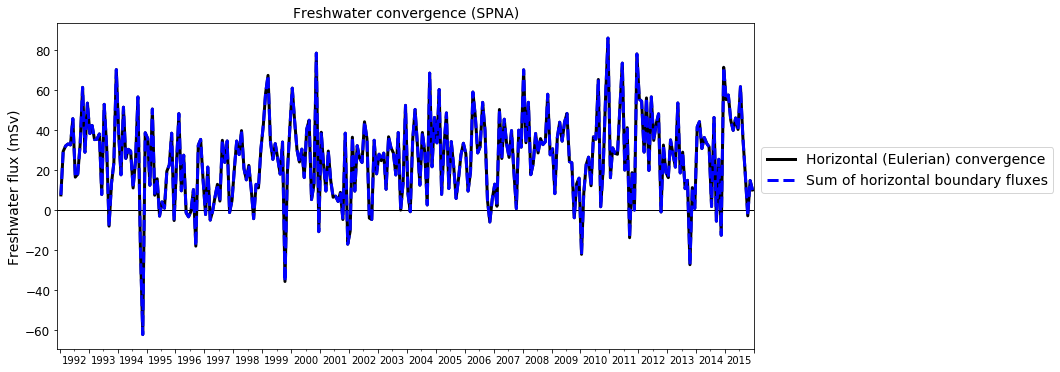

In [38]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_hConvFWe')*1e3, lw=3, color='k',
        label='Horizontal (Eulerian) convergence')
ax.plot(ConvFWe_spna_bnd.time, ConvFWe_spna_bnd*1e3, lw=3, color='b',ls='--',
        label='Sum of horizontal boundary fluxes')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

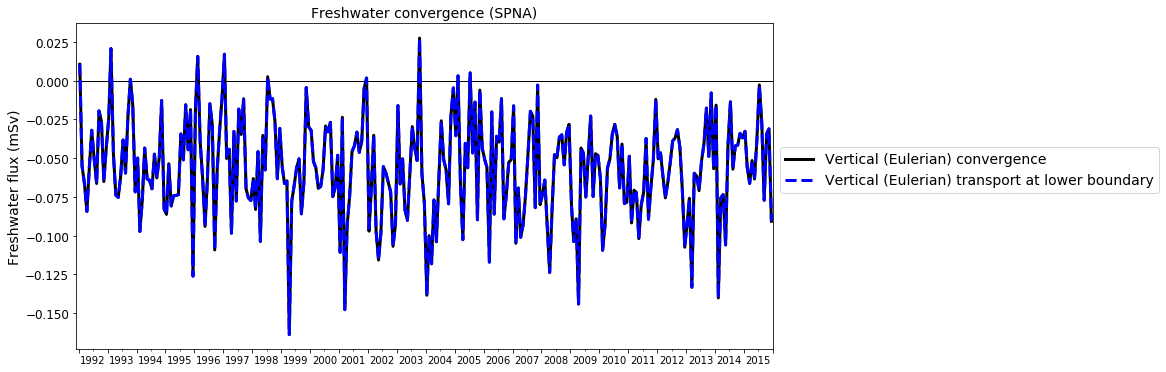

In [39]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_vConvFWe'), lw=3, color='k',
        label='Vertical (Eulerian) convergence')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='w_trspFWe'), lw=3, color='b',ls='--',
        label='Vertical (Eulerian) transport at lower boundary')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

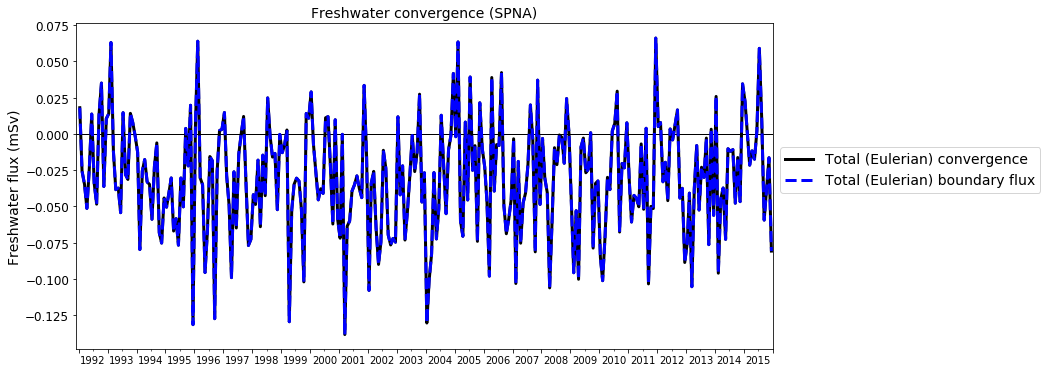

In [40]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_ConvFWe'), lw=3, color='k',
        label='Total (Eulerian) convergence')
ax.plot(budg_fw.time, ConvFWe_spna_bnd+budg_fw.sel(region='spna',term='w_trspFWe'), lw=3, color='b',ls='--',
        label='Total (Eulerian) boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

In [36]:
ConvFWb_spna_bnd = fw_btrsp.sel(section='Newfoundland Iberia') + fw_btrsp.sel(section='English Channel') \
                    - fw_btrsp.sel(section='Hudson Strait') - fw_btrsp.sel(section='Davis Strait') \
                    - fw_btrsp.sel(section='Denmark Strait') - fw_btrsp.sel(section='Iceland Faroe') \
                    - fw_btrsp.sel(section='Faroe Scotland')

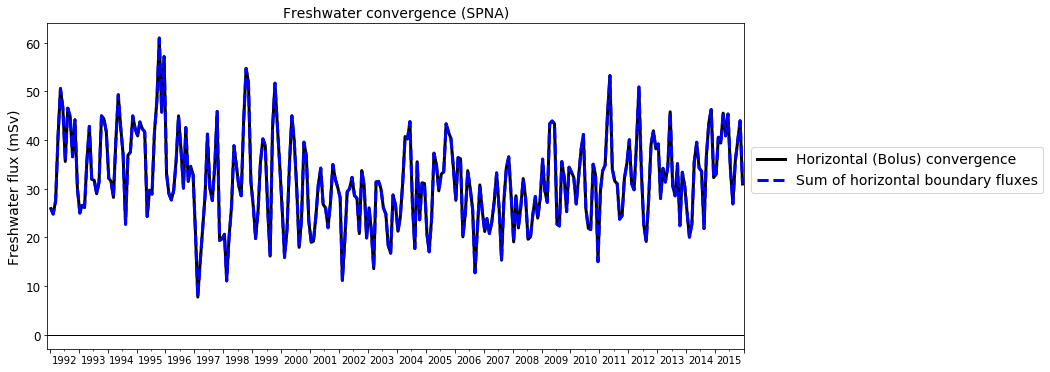

In [37]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_hConvFWb')*1e3, lw=3, color='k',
        label='Horizontal (Bolus) convergence')
ax.plot(ConvFWb_spna_bnd.time, ConvFWb_spna_bnd*1e3, lw=3, color='b',ls='--',
        label='Sum of horizontal boundary fluxes')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

In [91]:
budg_fw.coords['term']

<xarray.DataArray 'term' (term: 13)>
array(['tendFw', 'forcFw', 'adv_hConvFWe', 'adv_vConvFWe', 'adv_ConvFWe',
       'adv_hConvFWb', 'adv_vConvFWb', 'adv_ConvFWb', 'adv_ConvFw', 'totalFw',
       'lfwc', 'psal', 'dif_ConvFw'], dtype=object)
Coordinates:
  * term     (term) object 'tendFw' 'forcFw' ... 'psal' 'dif_ConvFw'

In [41]:
ConvFWe_nsea_bnd = fw_etrsp.sel(section='Denmark Strait') + fw_etrsp.sel(section='Iceland Faroe') \
                    + fw_etrsp.sel(section='Faroe Scotland') + fw_etrsp.sel(section='Scotland Norway') \
                    - fw_etrsp.sel(section='Fram Strait') - fw_etrsp.sel(section='Barents Sea')

ConvFWb_nsea_bnd = fw_btrsp.sel(section='Denmark Strait') + fw_btrsp.sel(section='Iceland Faroe') \
                    + fw_btrsp.sel(section='Faroe Scotland') + fw_btrsp.sel(section='Scotland Norway') \
                    - fw_btrsp.sel(section='Fram Strait') - fw_btrsp.sel(section='Barents Sea')

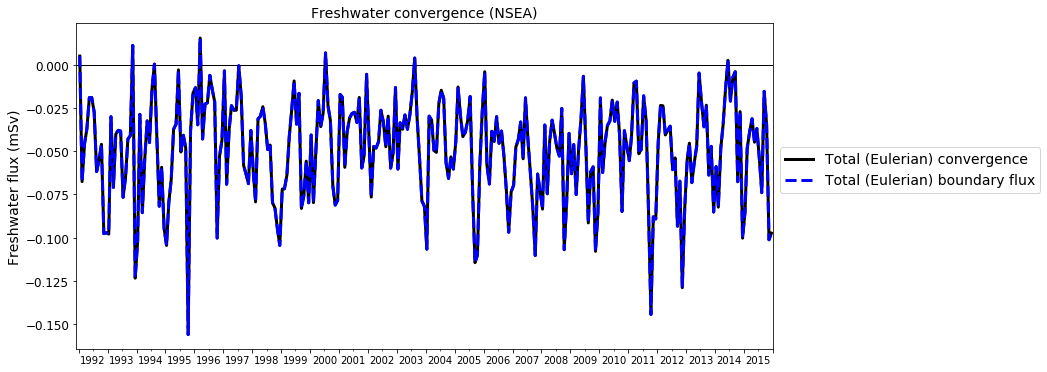

In [42]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='adv_ConvFWe'), lw=3, color='k',
        label='Total (Eulerian) convergence')
ax.plot(budg_fw.time, ConvFWe_nsea_bnd+budg_fw.sel(region='nsea',term='w_trspFWe'), lw=3, color='b',ls='--',
        label='Total (Eulerian) boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

In [43]:
ConvFWe_lsea_bnd = fw_etrsp.sel(section='Labrador Greenland') - fw_etrsp.sel(section='Hudson Strait') \
                    - fw_etrsp.sel(section='Davis Strait')

ConvFWb_lsea_bnd = fw_btrsp.sel(section='Labrador Greenland') - fw_btrsp.sel(section='Hudson Strait') \
                    - fw_btrsp.sel(section='Davis Strait')

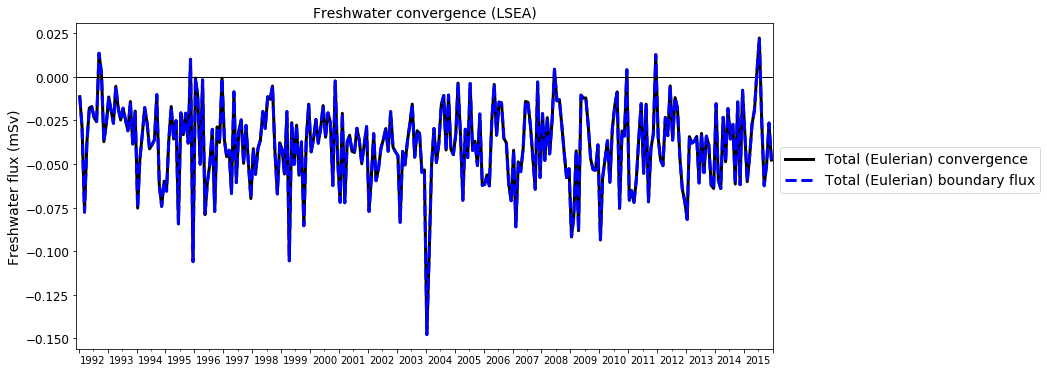

In [44]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='adv_ConvFWe'), lw=3, color='k',
        label='Total (Eulerian) convergence')
ax.plot(budg_fw.time, ConvFWe_lsea_bnd+budg_fw.sel(region='lsea',term='w_trspFWe'), lw=3, color='b',ls='--',
        label='Total (Eulerian) boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

### Average salinity, LFWC and time-integrated tendency

In [52]:
psal = budg_fw.sel(region='lsea',term='psal') - budg_fw.sel(region='lsea',term='psal').mean('time')
lfwc = budg_fw.sel(region='lsea',term='lfwc') - budg_fw.sel(region='lsea',term='lfwc').mean('time')

tend = (budg_fw.sel(region='lsea',term='tendFw').isel(time=slice(1, -1))\
        *main.isel(time=slice(1, -1)).dt).cumsum(dim='time')
tend = tend - tend.mean('time')

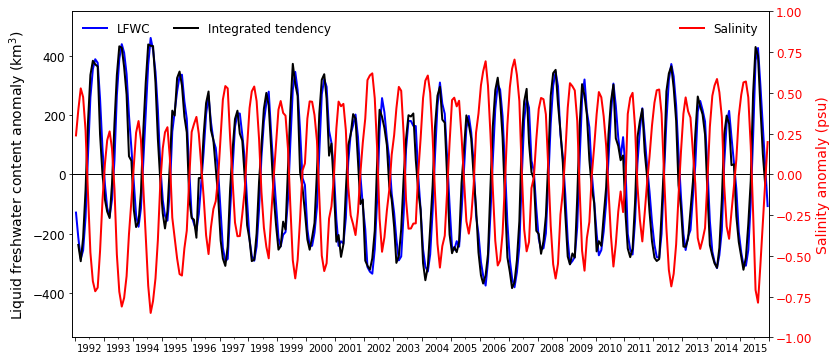

In [65]:
fig, ax1 = plt.subplots(figsize=(15,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(lfwc.time, lfwc*1e-9, lw=2, color='b',linestyle='-',label='LFWC')
ax1.plot(tend.time, tend*1e-3, lw=2, color='k',linestyle='-',label='Integrated tendency')

ax1.set_xlim(['1991-12-01','2016-01-01'])
ax1.set_ylim([-550,550])
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('Liquid freshwater content anomaly (km$^3$)',fontsize=14)
ax1.legend(loc='upper left',frameon=False,ncol=2,fontsize=12)
for tl in ax1.get_yticklabels():
    tl.set_color('k')
    tl.set_fontsize(12)

ax1.xaxis.set_major_locator(dates.YearLocator())
ax1.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax1.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
    
ax2 = ax1.twinx()
ax2.plot(psal.time, psal, lw=2, color='r',linestyle='-',label='Salinity')

ax2.set_xlim(['1991-12-01','2016-01-01'])
ax2.set_ylim([-1,1])

ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_ylabel(r'Salinity anomaly (psu)', color='r', fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(12)

ax2.legend(loc='upper right',frameon=False,fontsize=12)

ax2.xaxis.set_major_locator(dates.YearLocator())
ax2.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax2.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
    
fig.subplots_adjust(right=0.77)
plt.show()

In [66]:
psal_anom = psal.groupby('time.month') - psal.groupby('time.month').mean('time')
lfwc_anom = lfwc.groupby('time.month') - lfwc.groupby('time.month').mean('time')
tend_anom = tend.groupby('time.month') - tend.groupby('time.month').mean('time')

In [72]:
ts = [pd.to_datetime('2008-06-01'),pd.to_datetime('2010-06-01'),pd.to_datetime('2011-06-01'),
      pd.to_datetime('2012-06-01'),pd.to_datetime('2015-06-01')]

te = [pd.to_datetime('2008-10-31'),pd.to_datetime('2010-10-31'),pd.to_datetime('2011-10-31'),
      pd.to_datetime('2012-10-31'),pd.to_datetime('2015-10-31')]

In [99]:
en = xr.open_dataset('/mnt/efs/data/salinity.nc')
nc = xr.open_dataset('/mnt/efs/data/hadobs_en4_area.nc')
en['area'] = nc.area
en.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

In [100]:
# Salinity field
sal_en = en.salinity.sel(time=slice('1992-01-01','2015-12-31'),depth=slice(0,20),
                         lat=slice(50,70),lon=slice(-70,-40)).salem.roi(shape=gdf_lsea.loc[[0]])

# Layer thickness
depth_bnds = en.depth_bnds.sel(depth=slice(0,20))
dz = (depth_bnds[:,1]-depth_bnds[:,0])

# Area
area_en = en.area.sel(lat=slice(50,70),lon=slice(-70,-40)).salem.roi(shape=gdf_lsea.loc[[0]])

# Volume
vol_en = dz*area_en

# Average salinity in the Labrador Sea
psal_en = (sal_en*vol_en).sum(dim=['depth','lat','lon'])/((sal_en/sal_en)*vol_en).sum(dim=['depth','lat','lon'])

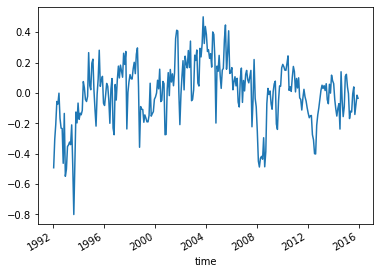

In [103]:
psal_en_anom = psal_en.groupby('time.month') - psal_en.groupby('time.month').mean('time')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


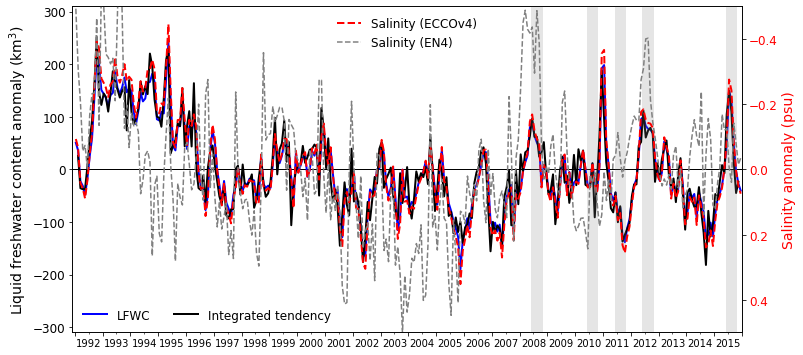

In [107]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

ax1.plot(lfwc_anom.time, lfwc_anom*1e-9, lw=2, color='b',linestyle='-',label='LFWC')
ax1.plot(tend_anom.time, tend_anom*1e-3, lw=2, color='k',linestyle='-',label='Integrated tendency')

ax1.set_xlim(['1991-12-01','2016-01-01'])
ax1.set_ylim([-310,310])
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('Liquid freshwater content anomaly (km$^3$)',fontsize=14)
ax1.legend(loc='lower left',frameon=False,ncol=2,fontsize=12)
for tl in ax1.get_yticklabels():
    tl.set_color('k')
    tl.set_fontsize(12)

ax1.xaxis.set_major_locator(dates.YearLocator())
ax1.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax1.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
    
ax2 = ax1.twinx()
ax2.plot(psal_anom.time, psal_anom, lw=2, color='r',linestyle='--',label='Salinity (ECCOv4)')
ax2.plot(psal_en_anom.time, psal_en_anom, lw=1.5, color='grey', linestyle='--',label='Salinity (EN4)')


ax2.set_xlim(['1991-12-01','2016-01-01'])
ax2.set_ylim([-0.5,0.5])
ax2.invert_yaxis()

ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_ylabel(r'Salinity anomaly (psu)', color='r', fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(12)

ax2.legend(loc='upper center',frameon=False,fontsize=12)

ax2.xaxis.set_major_locator(dates.YearLocator())
ax2.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax2.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

for a,b in zip(ts,te):
    ax2.fill([a,b,b,a],[-1,-1,1,1],'grey', alpha=0.2, edgecolor='None')

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()